In [1]:
pip install torchsummary


In [7]:
import torchvision
import numpy as np
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Download dataset using kagglehub
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

# Set dataset paths
train_dataset_path = os.path.join(path, "seg_train/seg_train")
validation_dataset_path = os.path.join(path, "seg_test/seg_test")

IMG_SIZE = 150
BATCH_SIZE = 32

# Data transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
validation_dataset = datasets.ImageFolder(root=validation_dataset_path, transform=transform)

# Split datasets into 50% each
train_size = int(0.5 * len(train_dataset))
val_size = int(0.5 * len(validation_dataset))
train_subset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
val_subset, _ = random_split(validation_dataset, [val_size, len(validation_dataset) - val_size])

# Data loaders for reduced-size datasets
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Reduced Train Size: {len(train_subset)}, Reduced Validation Size: {len(val_subset)}")

# Get class labels
labels = train_dataset.classes
print(f"Class labels: {labels}")



Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2
Reduced Train Size: 7017, Reduced Validation Size: 1500
Class labels: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


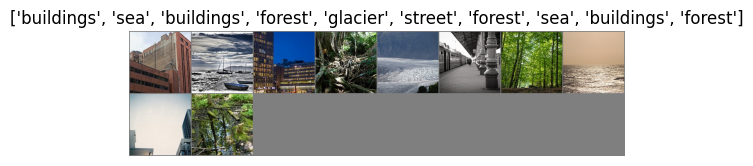

In [9]:
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

dataiter = iter(train_loader)
images, labels_batch = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]), title=[labels[l] for l in labels_batch[:10]])



In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm = nn.BatchNorm2d
        self.fc1 = nn.Linear(32 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 6)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)


CNN(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc.append(100 * val_correct / val_total)
        val_loss.append(val_running_loss / len(val_loader))
        scheduler.step(val_running_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

    return train_loss, train_acc, val_loss, val_acc

train_loss, train_acc, val_loss, val_acc = train_model(cnn_model, criterion, optimizer, scheduler)



Epoch [1/50] Train Loss: 0.3326, Train Acc: 88.26% | Val Loss: 0.7482, Val Acc: 76.53%
Epoch [2/50] Train Loss: 0.3194, Train Acc: 88.88% | Val Loss: 0.7313, Val Acc: 76.53%
Epoch [3/50] Train Loss: 0.2173, Train Acc: 92.35% | Val Loss: 0.8583, Val Acc: 76.93%
Epoch [4/50] Train Loss: 0.2244, Train Acc: 92.08% | Val Loss: 0.9400, Val Acc: 74.87%
Epoch [5/50] Train Loss: 0.1650, Train Acc: 93.87% | Val Loss: 0.9385, Val Acc: 76.80%
Epoch [6/50] Train Loss: 0.0949, Train Acc: 96.84% | Val Loss: 0.8582, Val Acc: 79.13%
Epoch [7/50] Train Loss: 0.0734, Train Acc: 97.78% | Val Loss: 0.9085, Val Acc: 78.93%
Epoch [8/50] Train Loss: 0.0634, Train Acc: 97.95% | Val Loss: 0.9516, Val Acc: 79.07%
Epoch [9/50] Train Loss: 0.0604, Train Acc: 98.09% | Val Loss: 0.9714, Val Acc: 78.93%
Epoch [10/50] Train Loss: 0.0585, Train Acc: 98.00% | Val Loss: 0.9700, Val Acc: 79.13%
Epoch [11/50] Train Loss: 0.0458, Train Acc: 98.46% | Val Loss: 1.0373, Val Acc: 78.80%
Epoch [12/50] Train Loss: 0.0486, Train A

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [15/50] Train Loss: 0.0425, Train Acc: 98.69% | Val Loss: 1.0391, Val Acc: 79.33%
Epoch [16/50] Train Loss: 0.0383, Train Acc: 98.79% | Val Loss: 1.0432, Val Acc: 79.33%
Epoch [17/50] Train Loss: 0.0400, Train Acc: 98.69% | Val Loss: 1.0453, Val Acc: 79.33%
Epoch [18/50] Train Loss: 0.0376, Train Acc: 98.73% | Val Loss: 1.0457, Val Acc: 79.53%
Epoch [19/50] Train Loss: 0.0362, Train Acc: 98.89% | Val Loss: 1.0467, Val Acc: 79.40%
Epoch [20/50] Train Loss: 0.0389, Train Acc: 98.67% | Val Loss: 1.0466, Val Acc: 79.53%
Epoch [21/50] Train Loss: 0.0417, Train Acc: 98.79% | Val Loss: 1.0474, Val Acc: 79.47%
Epoch [22/50] Train Loss: 0.0351, Train Acc: 98.83% | Val Loss: 1.0475, Val Acc: 79.60%
Epoch [23/50] Train Loss: 0.0370, Train Acc: 98.80% | Val Loss: 1.0483, Val Acc: 79.47%
Epoch [24/50] Train Loss: 0.0384, Train Acc: 98.90% | Val Loss: 1.0484, Val Acc: 79.47%
Epoch [25/50] Train Loss: 0.0403, Train Acc: 98.65% | Val Loss: 1.0484, Val Acc: 79.47%
Epoch [26/50] Train Loss: 0.0393

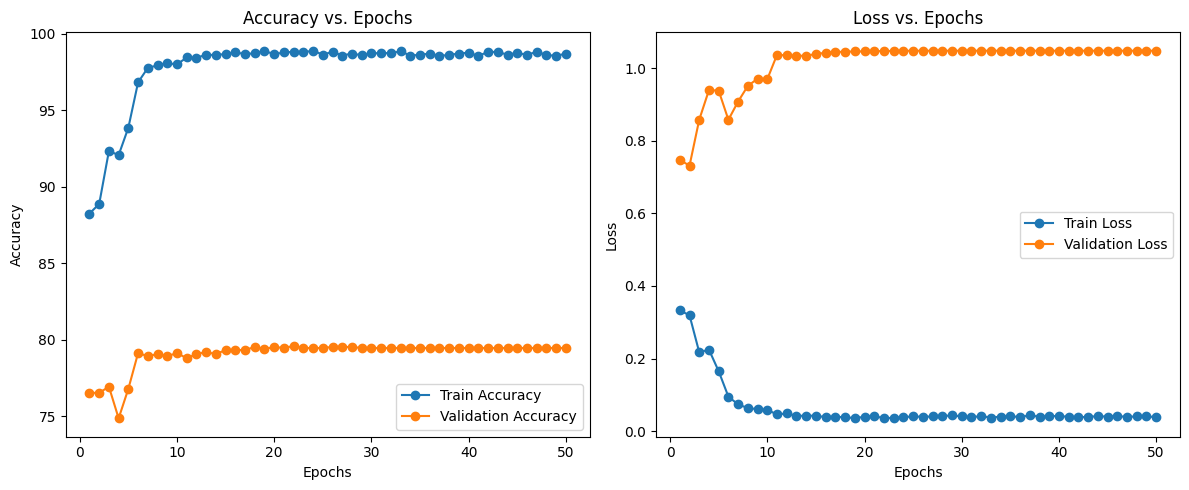

In [16]:
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'o-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'o-', label='Train Loss')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
# Download dataset using kagglehub
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

# Set test dataset path
test_dataset_path = os.path.join(path, "seg_test/seg_test")

# Load test dataset
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred = [], []

# Switch model to evaluation mode
cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate and print classification report
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2
              precision    recall  f1-score   support

   buildings       0.75      0.75      0.75       437
      forest       0.92      0.93      0.93       474
     glacier       0.78      0.77      0.78       553
    mountain       0.76      0.76      0.76       525
         sea       0.82      0.83      0.82       510
      street       0.79      0.79      0.79       501

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.80      0.81      0.80      3000



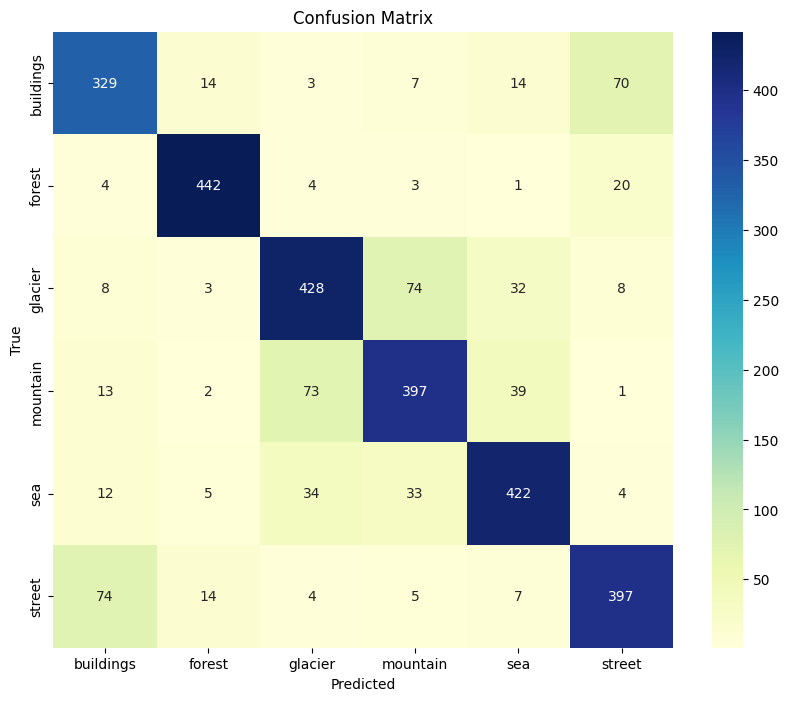

In [20]:
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



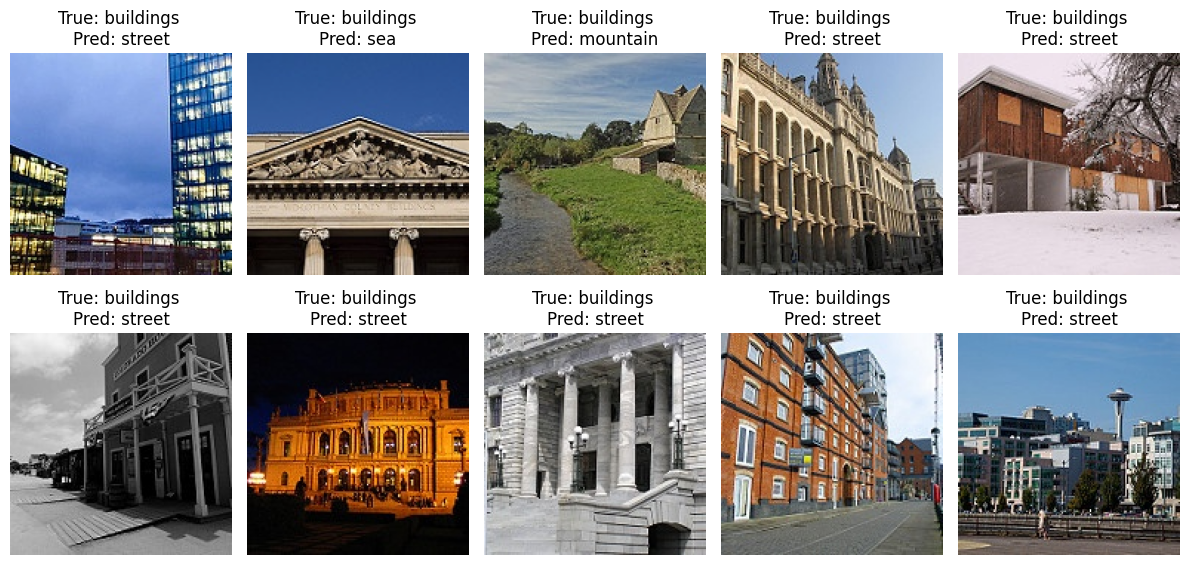

In [21]:
incorrect = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    idx = incorrect[i]
    img, true_label = test_dataset[idx]
    ax.imshow(img.permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(f"True: {test_dataset.classes[true_label]} \nPred: {test_dataset.classes[y_pred[idx]]}")
    ax.axis("off")
plt.tight_layout()
plt.show()
